**Imports**

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif
from sklearn.metrics import recall_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

---------
**Read Data**

In [58]:
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'datasets','data.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [60]:
# We can drop ID column, as it is not useful for our analysis
# We can drop the Unnamed: 32 column as it is empty (All nulls)
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

In [61]:
#replace spaces in column names with underscore
df.columns = df.columns.str.replace(' ', '_')

In [62]:
#Diagnostic column is our target column so separate the dataset into X and y
y= df['diagnosis']
X = df.drop('diagnosis', axis=1)


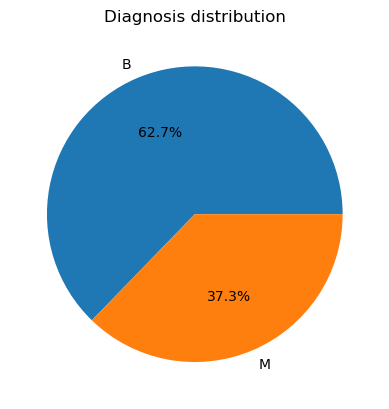

In [63]:
#a bit imbalanced dataset
plt.pie(y.value_counts(), labels=y.value_counts().index, autopct='%1.1f%%');
plt.title('Diagnosis distribution');

In [64]:
#y is categorical, so we need to encode it where Malignant is 1 and Benign is 0
y = y.map({'M':1, 'B':0})
y.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [65]:
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


-----
**Feature Selection**

<Axes: >

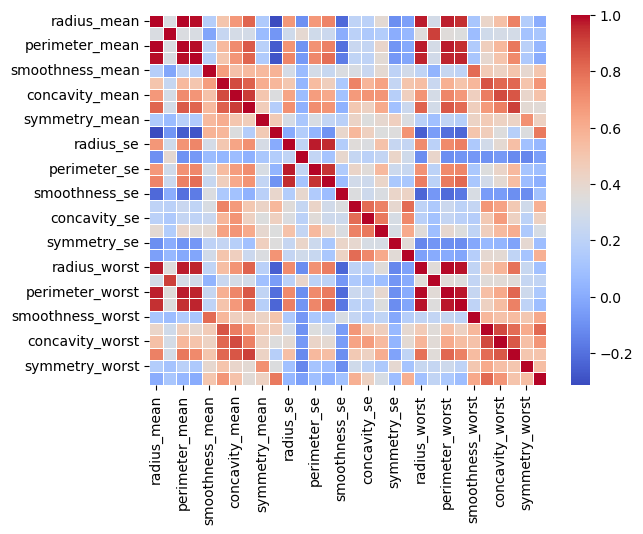

In [66]:
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

In [67]:
#As seen, Many columns are highly correlated so there's multicollinearity in the dataset
#We can drop some columns which are highly correlated with other columns
drop_columns = ['perimeter_mean',  'area_mean', 'perimeter_se',
                'area_se','perimeter_worst','area_worst',
                'radius_worst', 'texture_worst', 'concavity_mean',
                'concave_points_worst', 'compactness_mean', 'compactness_worst',
                'compactness_se', 'smoothness_worst', 'concave_points_mean'
                ]
X.drop(drop_columns, axis=1, inplace=True)


<Axes: >

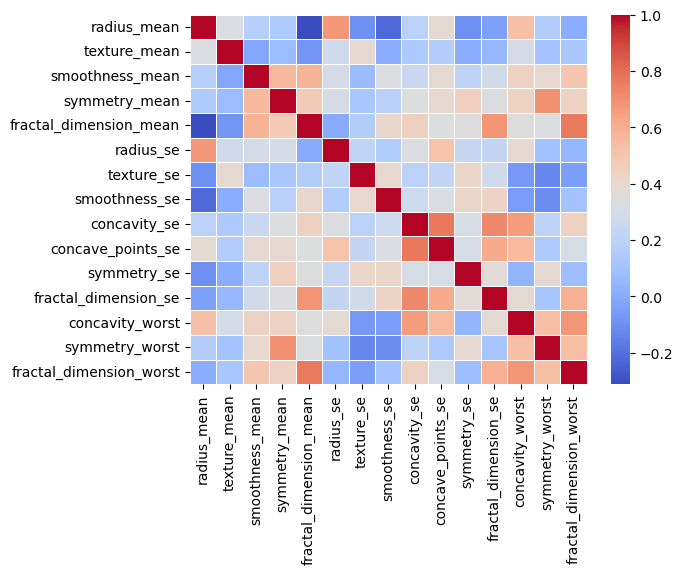

In [68]:
#Check Again for correlation
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', linewidths=0.5, fmt=".2f")

In [69]:
#Extract columns with correlation > 0.8 | < -0.8
corr_matrix = X.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var= [(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[]

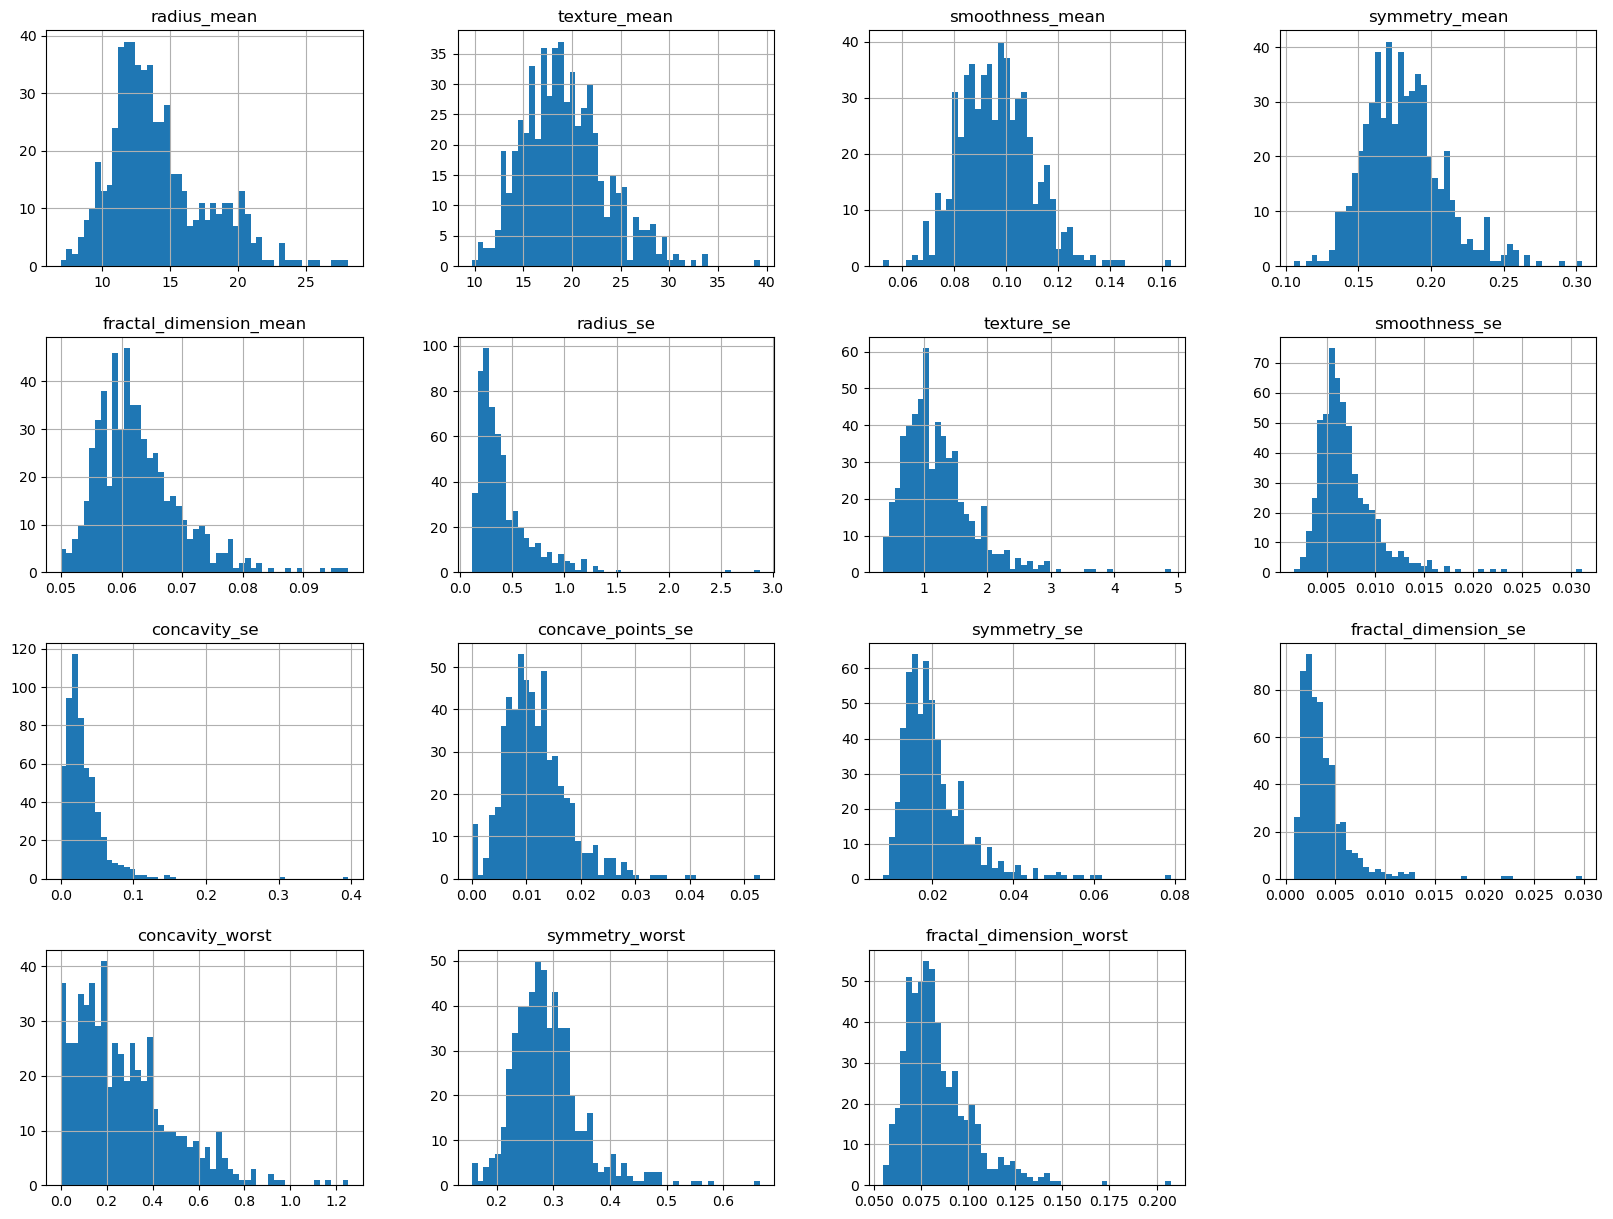

In [70]:
X.hist(bins=50, figsize=(20,15));

In [71]:
#Hypothesis testing of features (numerical) with target (categorical) using ANOVA**
selector = f_classif(X, y)
p_values = pd.Series(selector[1])
p_values.index = X.columns
p_values[p_values>0.05].sort_values(ascending=False)

symmetry_se               0.876642
texture_se                0.843332
fractal_dimension_mean    0.759937
smoothness_se             0.110297
fractal_dimension_se      0.063074
dtype: float64

In [72]:
#Drop columns with p_value > 0.1
X.drop(p_values[p_values>0.1].index, axis=1, inplace=True)

-----
**Split data to train & test**

In [73]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42,stratify=y)

In [74]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((455, 11), (455,), (114, 11), (114,))

----
**Use class weights to overcome imbalanced dataset problem**

In [75]:
val_count = 1 - (np.bincount(y_train) / len(y_train))
val_count = val_count / sum(val_count)
dict_weights = {}
for i in range(2): 
    dict_weights[i] = val_count[i]

dict_weights

{0: 0.37362637362637363, 1: 0.6263736263736264}

----
**Modeling**

Choose Recall as the evaluation metric 
because it doesn’t matter whether we raise a false alarm but the actual positive cases should not go undetected!

**1-Logistic Regression**

In [76]:
#Logistic Regression without class weights
log_reg = LogisticRegression(random_state=42)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print('Recall Score on train data:', recall_score(y_train, log_reg.predict(X_train)))
print('Recall Score on test data:', recall_score(y_test, y_pred))

Recall Score on train data: 0.888235294117647
Recall Score on test data: 0.8333333333333334


In [77]:
#Logistic Regression with class weights
log_reg = LogisticRegression(random_state=42, class_weight=dict_weights)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print('Recall Score on train data:', recall_score(y_train, log_reg.predict(X_train)))
print('Recall Score on test data:', recall_score(y_test, y_pred))


Recall Score on train data: 0.9058823529411765
Recall Score on test data: 0.8809523809523809


**2- RandomForest Classifier**

In [78]:
#RFC without class weights
rfc = RandomForestClassifier(n_estimators=110, max_depth=3, random_state=42,)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('Recall Score on train data:', recall_score(y_train, rfc.predict(X_train)))
print('Recall Score on test data:', recall_score(y_test, y_pred))

Recall Score on train data: 0.9352941176470588
Recall Score on test data: 0.9047619047619048


In [79]:
#RFC with class weights
rfc = RandomForestClassifier(n_estimators=110, max_depth=3, random_state=42, class_weight=dict_weights)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('Recall Score on train data:', recall_score(y_train, rfc.predict(X_train)))
print('Recall Score on test data:', recall_score(y_test, y_pred))

Recall Score on train data: 0.9647058823529412
Recall Score on test data: 0.9523809523809523


In [80]:
#Use GridSearchCV to find the best parameters for RFC
rfc = RandomForestClassifier(random_state=42, class_weight=dict_weights)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=5, n_jobs=-1, verbose=2,scoring='recall')
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\Galhom\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


In [81]:
#use the best parameters to train the model
rfc = grid_search.best_estimator_
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('Recall Score on train data:', recall_score(y_train, rfc.predict(X_train)))
print('Recall Score on test data:', recall_score(y_test, y_pred))

Recall Score on train data: 0.9882352941176471
Recall Score on test data: 0.9047619047619048


In [82]:
#dump the model 
ARTIFACTS_FOLDER_PATH = os.path.join(os.path.dirname(os.getcwd()), 'artifacts')
os.makedirs(ARTIFACTS_FOLDER_PATH, exist_ok=True)

joblib.dump(rfc, os.path.join(ARTIFACTS_FOLDER_PATH, 'rfc_best_model.pkl'))

['d:\\Abdelrahman\\BreastCancerProject\\artifacts\\rfc_best_model.pkl']

**3-XGBClassifier**

In [83]:
xgb_model = xgb.XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print('Recall Score on train data:', recall_score(y_train, xgb_model.predict(X_train)))
print('Recall Score on test data:', recall_score(y_test, y_pred))

Recall Score on train data: 1.0
Recall Score on test data: 0.9047619047619048


In [84]:
#Use GridSearchCV to find the best parameters for XGB
xgb_model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2,scoring='recall')
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200}


In [85]:
#use the best parameters to train the model
xgb_model = grid_search.best_estimator_
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print('Recall Score on train data:', recall_score(y_train, xgb_model.predict(X_train)))
print('Recall Score on test data:', recall_score(y_test, y_pred))

Recall Score on train data: 1.0
Recall Score on test data: 0.9047619047619048


In [86]:
#dump the model
joblib.dump(xgb_model, os.path.join(ARTIFACTS_FOLDER_PATH, 'xgb_best_model.pkl'))


['d:\\Abdelrahman\\BreastCancerProject\\artifacts\\xgb_best_model.pkl']

----